In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wntr
cmap=plt.cm.get_cmap('viridis')
import seaborn as sns
cmap=plt.cm.get_cmap('viridis')

In [7]:
file = 'C:/Saraswati/Uma Sima Urban pipeline Project Network 1.inp'
wn = wntr.network.WaterNetworkModel(file)

In [8]:
# Define simulation parameters 
start_time = 2*3600 # 2 hours
break_duration = 12*3600 # 12 hours
total_duration = start_time + break_duration # 14 hours

minimum_pressure = 3.52 # 5 psi
required_pressure = 5.06 # 20 psi 

min_pipe_diam = 0.050 # 2 inch

In [9]:
# Calculate average expected demand and identify junctions with non-zero average expected demand (AED)
AED = wntr.metrics.average_expected_demand(wn)
nzd_junct = AED[AED > 0].index


In [10]:
# Set hydraulic parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure 

In [11]:
# Run simulation
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()


In [12]:
# Save junction pressure results and identify junctions that fall below minimum pressure
pressure = results.node['pressure'].loc[start_time::, nzd_junct]
normal_pressure_below_pmin = pressure.columns[(pressure < minimum_pressure).any()]


In [13]:
# Queries all pipes with diameter greater than threshold set in 1c
pipes_of_interest = wn.query_link_attribute('diameter', np.greater_equal, min_pipe_diam)
# Create dictionary to save results
analysis_results = {} 


In [15]:
# Simulate pipe break (simulated as pipe closures) for each pipe
for pipe_name in pipes_of_interest.index: 
    wn = wntr.network.WaterNetworkModel(file)
    wn.options.hydraulic.demand_model = 'PDD'    
    wn.options.time.duration = total_duration
    wn.options.hydraulic.minimum_pressure = minimum_pressure
    wn.options.hydraulic.required_pressure = required_pressure
    #print(pipe_name)
# Create pipe closure control and apply to pipe of interest
    pipe = wn.get_link(pipe_name)
    act = wntr.network.controls.ControlAction(pipe, 'status', 0)
    cond = wntr.network.controls.SimTimeCondition(wn, 'Above', start_time)
    ctrl = wntr.network.controls.Control(cond, act)
    wn.add_control('close pipe ' + pipe_name, ctrl)
    
    try:
        # Simulate hydraulics
        sim = wntr.sim.WNTRSimulator(wn) 
        sim_results = sim.run_sim()

        # Using pressure results, identify impacted junctions
        sim_pressure = sim_results.node['pressure'].loc[start_time::, nzd_junct]
        sim_pressure_below_pmin = sim_pressure.columns[(sim_pressure < minimum_pressure).any()]
        impacted_junctions = set(sim_pressure_below_pmin) - set(normal_pressure_below_pmin)
        
    except Exception as e:
        # Identify failed simulations and the reason
        impacted_junctions = None
        print(pipe_name, ' Failed:', e)

    finally:
        # Save simulation results
        analysis_results[pipe_name] = impacted_junctions

In [16]:
# Save junction impact results to dictionary
num_junctions_impacted = {}
for pipe_name, impacted_junctions in analysis_results.items():
    if impacted_junctions is not None:
        num_junctions_impacted[pipe_name] = len(impacted_junctions)
        

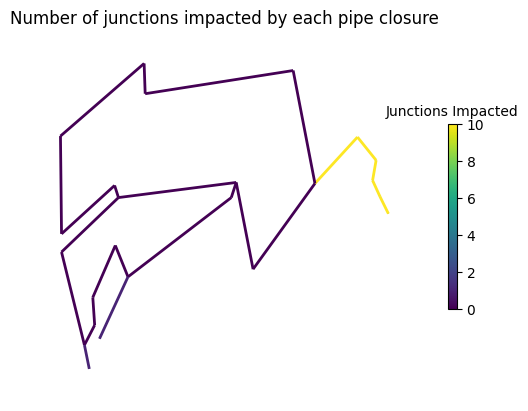

<AxesSubplot:title={'center':'Number of junctions impacted by each pipe closure'}>

In [18]:
#Plot junctions impacted due to pipe breaks
wntr.graphics.plot_network(wn, link_attribute=num_junctions_impacted, node_size=0, link_width=2, 
                           link_range=[0,10], link_cmap = cmap, link_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each pipe closure')